In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from pymongo import MongoClient
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from talib import abstract

from functools import partial

In [2]:
#Download Data from yahoo
### TEST Scnarios - TCS- Bull ,ACC- modrate up (Sidewase),YESBank- Back to Zero ,ITC(stock dosnt even Move)
stock='TCS'
startdate='2007-01-01'
enddate='2022-01-01'
exchange=['.NS','.BO']
dfo = yf.download(stock+exchange[0],start=startdate)

[*********************100%***********************]  1 of 1 completed


In [3]:
## Making Copy of Dataframe for further analysis and changes
df=dfo.copy()
# Adding feild called % Daily changes out of 100%
df['pct_change']=(df['Adj Close'].pct_change())*100
df.dropna(inplace=True)

In [4]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2007-01-03   313.250000   322.000000   309.787506   320.037506   242.514069   
2007-01-04   321.250000   321.250000   312.524994   314.762512   238.516891   
2007-01-05   316.250000   317.149994   313.274994   315.750000   239.265182   
2007-01-08   314.750000   314.750000   303.750000   310.950012   235.627869   
2007-01-09   311.975006   315.462494   306.312500   314.100006   238.014877   
...                 ...          ...          ...          ...          ...   
2022-01-31  3749.000000  3758.000000  3721.399902  3736.250000  3736.250000   
2022-02-01  3770.000000  3808.000000  3736.399902  3800.649902  3800.649902   
2022-02-02  3827.899902  3864.000000  3800.649902  3856.199951  3856.199951   
2022-02-03  3851.000000  3882.500000  3816.050049  3824.600098  3824.600098   
2022-02-04  3815.300049  3824.699951  3769.000000  3814.899902  3814.899902   

             Volume  pct_change  
Date                             
2007-01-03  4384972    2.535048  
2007-01-04  3970700   -1.648225  
2007-01-05  2718740    0.313727  
2007-01-08  4951892   -1.520202  
2007-01-09  4020568    1.013042  
...             ...         ...  
2022-01-31  2739393    1.252014  
2022-02-01  2105169    1.723651  
2022-02-02  1984212    1.461593  
2022-02-03  1960538   -0.819456  
2022-02-04  2306676   -0.253626  

[3721 rows x 7 columns]

In [5]:

# To calculate Rolling weighted expontional moving average. alpha being used is 1/<moving average period>. You can play with alpha between 1-0  
# This will give me three thing 
#1. will Return Rolling Moving Average for the given period .Also will revove the rows where rolling MA value is NA .
#2. Will calcuate how many consicutive days price traded above or below Rolling MA.
#3. Will calculate how far price travlled (up or down )in term of % from Rolling moving Average .If % change is -ve means price moved below RMA otherwise above RMA.

##################### Here you can play with Windows and alpha ##########
def rwema(windows,df,field):
    
    for window in windows:
        alpha=1/window
        weights=list(reversed([(1-alpha)**n for n in range(window)]))
        ewma = partial(np.average, weights=weights)
        df['RWEMA_'+str(window)] = df[field].rolling(window).apply(ewma)
        
        df.dropna(inplace=True)
        ##########TO check how much  moving up or down from given point 
        count = 0
        cum_change=0
        base=[]
        for index, row in df.iterrows():
            if row['RWEMA_'+str(window)] <  row[field] :
                base.append(row[field])
                count += 1
                cum_change=((row[field]-base[0])/base[0])*100
                # cum_change=cum_change+row['pct_change']
            else:
                count = 0
                cum_change=0
                base.clear()
            df.loc[index, 'cum_above_0'] = count
            df.loc[index, 'cum_above_pct_change'] = cum_change

        count = 0
        cum_change=0
        base=[]
        for index, row in df.iterrows():
            if row['RWEMA_'+str(window)] >  row[field]:
                base.append(row[field])
                count -= 1
                cum_change=((row[field]-base[0])/base[0])*100
                # cum_change=cum_change+row['pct_change']
            else:
                count = 0
                cum_change=0
                base.clear()
            df.loc[index, 'cum_below_0'] = count
            df.loc[index, 'cum_below_pct_change'] = cum_change

        df['RWEMA_'+str(window)+'_movement']=df['cum_above_0']+df['cum_below_0']
        df['RWEMA_'+str(window)+'_price%movement']=df['cum_above_pct_change']+df['cum_below_pct_change']
        df.drop('cum_above_0',axis=1,inplace=True)
        df.drop('cum_below_0',axis=1,inplace=True)
        df.drop('cum_above_pct_change',axis=1,inplace=True)
        df.drop('cum_below_pct_change',axis=1,inplace=True)
    return df

# Stage - 1
## Basic Calculation
1. Calculate Moving Average
2. Calculate how many consicutive days price was trading above or below MA(RWEMA_252_movement)
3. Calculate Crossup and Cross Below Points.(Check)
4. Calculate how far price moved up or down from RMA (starting from day 1 of when crossed up or down)

## Output
1. How many times Price crossed above and below of MA
2. Price Skew w.r.t MA --> Postive means ,Price mostly traded above MA, -Ve means price traded below MA mostly .Large the % output ,Large the Skew towards that direction

In [6]:
window=[252]     #10 for week , 21 days a week -->53 days
field='Adj Close'
df=rwema(window,df,field)

In [7]:
#####RWEMA_<Days>_movement here is calculating number of days price stayed up or down of Moving average when crossed up or down .
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2008-01-07   250.000000   252.199997   243.125000   243.899994   186.840485   
2008-01-08   245.000000   248.000000   242.324997   246.962494   189.186523   
2008-01-09   248.699997   251.500000   247.475006   249.074997   190.804825   
2008-01-10   249.500000   252.375000   240.500000   245.412506   187.999100   
2008-01-11   228.837494   251.000000   228.837494   247.437500   189.550385   
...                 ...          ...          ...          ...          ...   
2022-01-31  3749.000000  3758.000000  3721.399902  3736.250000  3736.250000   
2022-02-01  3770.000000  3808.000000  3736.399902  3800.649902  3800.649902   
2022-02-02  3827.899902  3864.000000  3800.649902  3856.199951  3856.199951   
2022-02-03  3851.000000  3882.500000  3816.050049  3824.600098  3824.600098   
2022-02-04  3815.300049  3824.699951  3769.000000  3814.899902  3814.899902   

             Volume  pct_change    RWEMA_252  RWEMA_252_movement  \
Date                                                               
2008-01-07  3647344   -2.944662   213.777025                -1.0   
2008-01-08  3207732    1.255637   213.556674                -2.0   
2008-01-09  2450128    0.855400   213.356547                -3.0   
2008-01-10  3342376   -1.470469   213.137898                -4.0   
2008-01-11  2149188    0.825155   212.938219                -5.0   
...             ...         ...          ...                 ...   
2022-01-31  2739393    1.252014  3457.973900               400.0   
2022-02-01  2105169    1.723651  3460.587225               401.0   
2022-02-02  1984212    1.461593  3463.607400               402.0   
2022-02-03  1960538   -0.819456  3466.564350               403.0   
2022-02-04  2306676   -0.253626  3469.642794               404.0   

            RWEMA_252_price%movement  
Date                                  
2008-01-07                  0.000000  
2008-01-08                  1.255637  
2008-01-09                  2.121778  
2008-01-10                  0.620109  
2008-01-11                  1.450382  
...                              ...  
2022-01-31                 79.739323  
2022-02-01                 82.837401  
2022-02-02                 85.509741  
2022-02-03                 83.989571  
2022-02-04                 83.522924  

[3470 rows x 10 columns]

In [8]:
##################To mark all rows when its above (1) or below (-1)
# Also setting crossover to 1/1 when ever its crossing above or down.
df['check']=np.where((df['RWEMA_252_movement']>0),1,-1)

#####When Crossing above its 1 and when crossing below its -1 otherwise zero
conditions=[(df['RWEMA_252_movement']>0)&(df['RWEMA_252_movement'].shift(1)<0),(df['RWEMA_252_movement']<0)&(df['RWEMA_252_movement'].shift(1)>0)]
values=[1,-1]
df['crossover']=np.select(conditions,values)

In [9]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2008-01-07   250.000000   252.199997   243.125000   243.899994   186.840485   
2008-01-08   245.000000   248.000000   242.324997   246.962494   189.186523   
2008-01-09   248.699997   251.500000   247.475006   249.074997   190.804825   
2008-01-10   249.500000   252.375000   240.500000   245.412506   187.999100   
2008-01-11   228.837494   251.000000   228.837494   247.437500   189.550385   
...                 ...          ...          ...          ...          ...   
2022-01-31  3749.000000  3758.000000  3721.399902  3736.250000  3736.250000   
2022-02-01  3770.000000  3808.000000  3736.399902  3800.649902  3800.649902   
2022-02-02  3827.899902  3864.000000  3800.649902  3856.199951  3856.199951   
2022-02-03  3851.000000  3882.500000  3816.050049  3824.600098  3824.600098   
2022-02-04  3815.300049  3824.699951  3769.000000  3814.899902  3814.899902   

             Volume  pct_change    RWEMA_252  RWEMA_252_movement  \
Date                                                               
2008-01-07  3647344   -2.944662   213.777025                -1.0   
2008-01-08  3207732    1.255637   213.556674                -2.0   
2008-01-09  2450128    0.855400   213.356547                -3.0   
2008-01-10  3342376   -1.470469   213.137898                -4.0   
2008-01-11  2149188    0.825155   212.938219                -5.0   
...             ...         ...          ...                 ...   
2022-01-31  2739393    1.252014  3457.973900               400.0   
2022-02-01  2105169    1.723651  3460.587225               401.0   
2022-02-02  1984212    1.461593  3463.607400               402.0   
2022-02-03  1960538   -0.819456  3466.564350               403.0   
2022-02-04  2306676   -0.253626  3469.642794               404.0   

            RWEMA_252_price%movement  check  crossover  
Date                                                    
2008-01-07                  0.000000     -1          0  
2008-01-08                  1.255637     -1          0  
2008-01-09                  2.121778     -1          0  
2008-01-10                  0.620109     -1          0  
2008-01-11                  1.450382     -1          0  
...                              ...    ...        ...  
2022-01-31                 79.739323      1          0  
2022-02-01                 82.837401      1          0  
2022-02-02                 85.509741      1          0  
2022-02-03                 83.989571      1          0  
2022-02-04                 83.522924      1          0  

[3470 rows x 12 columns]

In [10]:
##To check how many times price crossed up and down of MA
up=df.groupby('crossover').Close.count()[1]
down=df.groupby('crossover').Close.count()[-1]
print(f"Price crossed up {up} times")
print(f"Price crossed below {down} times")

Price crossed up 51 times
Price crossed below 50 times


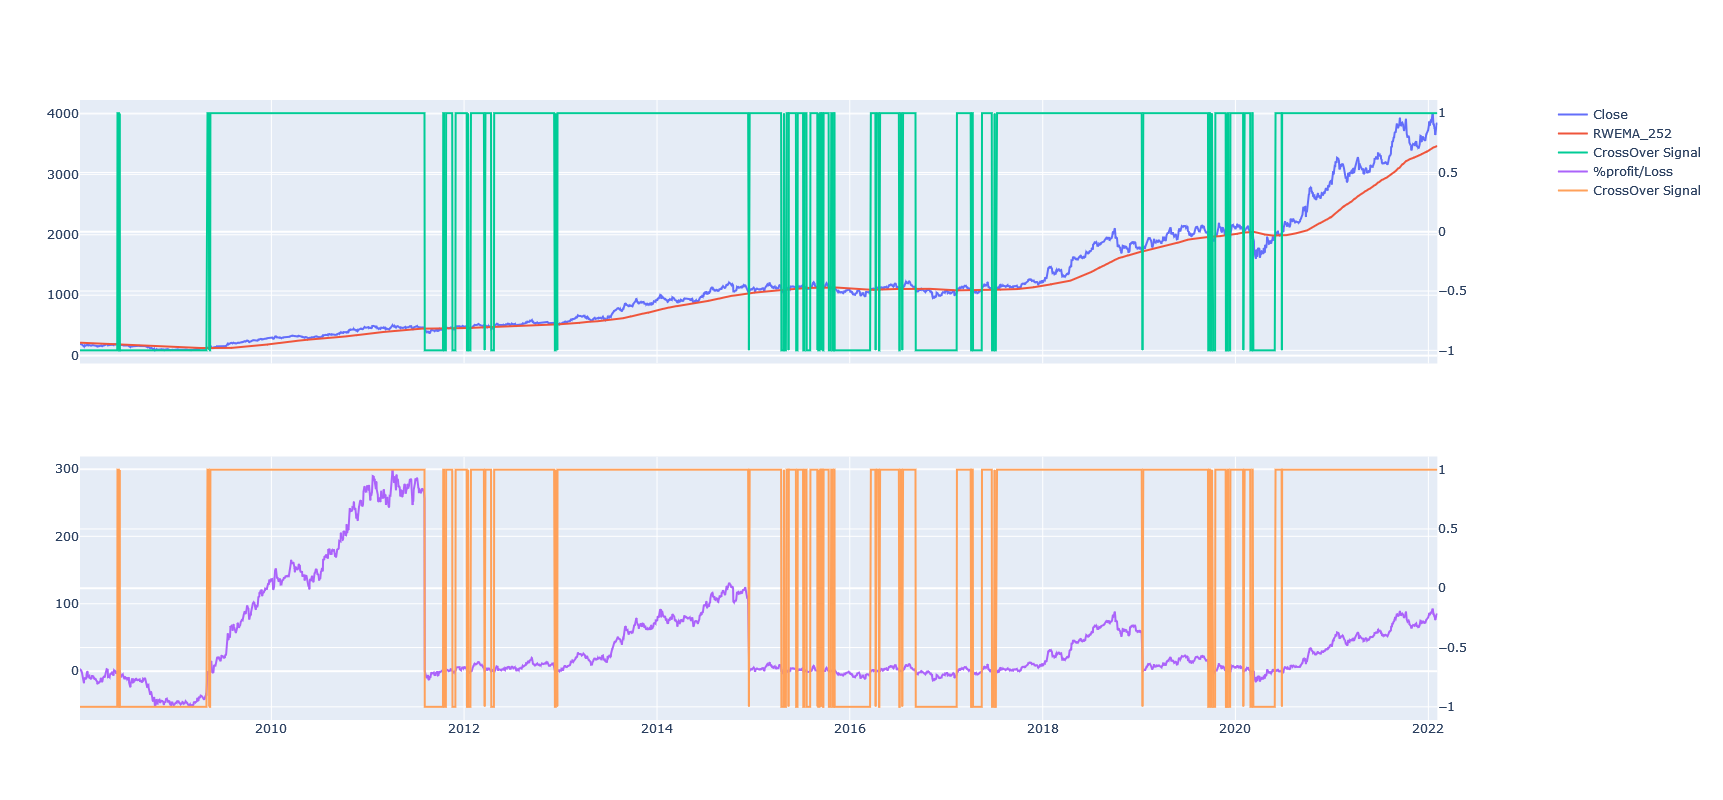

In [11]:
##################Ploting close,ma and check(to see when close crossing above or below of ma)
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,specs=[[{"secondary_y": True}],[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df.index,y=df['Adj Close'],mode='lines',name='Close'),secondary_y=False,row=1, col=1)
fig.add_trace(go.Scatter(x=df.index,y=df['RWEMA_252'],mode='lines',name='RWEMA_252'),secondary_y=False,row=1, col=1)
fig.add_trace(go.Scatter(x=df.index,y=df['check'],mode='lines',name='CrossOver Signal'),secondary_y=True,row=1, col=1)

fig.add_trace(go.Scatter(x=df.index,y=df['RWEMA_252_price%movement'],mode='lines',name='%profit/Loss'),secondary_y=False,row=2, col=1)
fig.add_trace(go.Scatter(x=df.index,y=df['check'],mode='lines',name='CrossOver Signal'),secondary_y=True,row=2, col=1)

fig.update_traces(dict(marker_line_width=0))
# fig = px.line(df[['Close','RWEMA_252','RWEMA_252_movement']],title="")
                
# fig.update_traces(marker_color='green')
fig.update_layout(autosize=False,width=1400,height=800,paper_bgcolor="white",)
fig.show()

In [12]:
#### Calculating Skew 
skew_data=df.groupby(df['check']).RWEMA_252_movement.count()

In [13]:
skew_data

check
-1     767
 1    2703
Name: RWEMA_252_movement, dtype: int64

In [14]:
skew_data=skew_data.to_frame()

In [15]:
## maximum total -ve Days
neg=skew_data.loc[skew_data.index<0].max()[0]
## maximum total +ve Days
pos=skew_data.loc[skew_data.index>0].max()[0]

## % MA Skew
skew=((pos-neg)/(pos+neg))*100
print(f"This Stock haing postive MA Skew of {round(skew,2)}% for MV 250 ")

This Stock haing postive MA Skew of 55.79% for MV 250 


### #####################################End of Stage-1#########################################################

# Stage - 2

In [61]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2008-01-07   250.000000   252.199997   243.125000   243.899994   186.840485   
2008-01-08   245.000000   248.000000   242.324997   246.962494   189.186523   
2008-01-09   248.699997   251.500000   247.475006   249.074997   190.804825   
2008-01-10   249.500000   252.375000   240.500000   245.412506   187.999100   
2008-01-11   228.837494   251.000000   228.837494   247.437500   189.550385   
...                 ...          ...          ...          ...          ...   
2022-01-31  3749.000000  3758.000000  3721.399902  3736.250000  3736.250000   
2022-02-01  3770.000000  3808.000000  3736.399902  3800.649902  3800.649902   
2022-02-02  3827.899902  3864.000000  3800.649902  3856.199951  3856.199951   
2022-02-03  3851.000000  3882.500000  3816.050049  3824.600098  3824.600098   
2022-02-04  3815.300049  3824.699951  3769.000000  3814.899902  3814.899902   

             Volume  pct_change    RWEMA_252  RWEMA_252_movement  \
Date                                                               
2008-01-07  3647344   -2.944662   213.777025                -1.0   
2008-01-08  3207732    1.255637   213.556674                -2.0   
2008-01-09  2450128    0.855400   213.356547                -3.0   
2008-01-10  3342376   -1.470469   213.137898                -4.0   
2008-01-11  2149188    0.825155   212.938219                -5.0   
...             ...         ...          ...                 ...   
2022-01-31  2739393    1.252014  3457.973900               400.0   
2022-02-01  2105169    1.723651  3460.587225               401.0   
2022-02-02  1984212    1.461593  3463.607400               402.0   
2022-02-03  1960538   -0.819456  3466.564350               403.0   
2022-02-04  2306676   -0.253626  3469.642794               404.0   

            RWEMA_252_price%movement  check  crossover  
Date                                                    
2008-01-07                  0.000000     -1          0  
2008-01-08                  1.255637     -1          0  
2008-01-09                  2.121778     -1          0  
2008-01-10                  0.620109     -1          0  
2008-01-11                  1.450382     -1          0  
...                              ...    ...        ...  
2022-01-31                 79.739323      1          0  
2022-02-01                 82.837401      1          0  
2022-02-02                 85.509741      1          0  
2022-02-03                 83.989571      1          0  
2022-02-04                 83.522924      1          0  

[3470 rows x 12 columns]

In [16]:
########### Here We are Calculating How Many Times Price Touched Specfic number of Days. 
data=df.groupby(df['RWEMA_252_movement']).Close.count()


In [17]:
# Just to validate the count
# df.loc[(df['RWEMA_252_movement']==-2) & (df['RWEMA_252_movement'].shift(1)==-1)].count()

In [18]:
df2=data.to_frame()
df2.reset_index(inplace=True)
df2.rename(columns={'RWEMA_252_movement':'#Days','Close':'#Times_Approched'},inplace=True)
df2.set_index('#Days',inplace=True)

In [19]:
df2.head()

#Times_Approched
#Days                   
-216.0                 1
-215.0                 1
-214.0                 1
-213.0                 1
-212.0                 1

In [20]:
####### Genric Information 
print(f"maximum number of days traded downside is {abs(df2.head(1).index[0])}")
print(f"maximum number of days traded upside is {abs(df2.tail(1).index[0])}")
df2.loc[df2.index>0].head(),df2.loc[df2.index<0].tail()

maximum number of days traded downside is 216.0
maximum number of days traded upside is 557.0


(       #Times_Approched
 #Days                  
 1.0                  51
 2.0                  40
 3.0                  34
 4.0                  30
 5.0                  29,
        #Times_Approched
 #Days                  
 -5.0                 17
 -4.0                 24
 -3.0                 28
 -2.0                 37
 -1.0                 51)

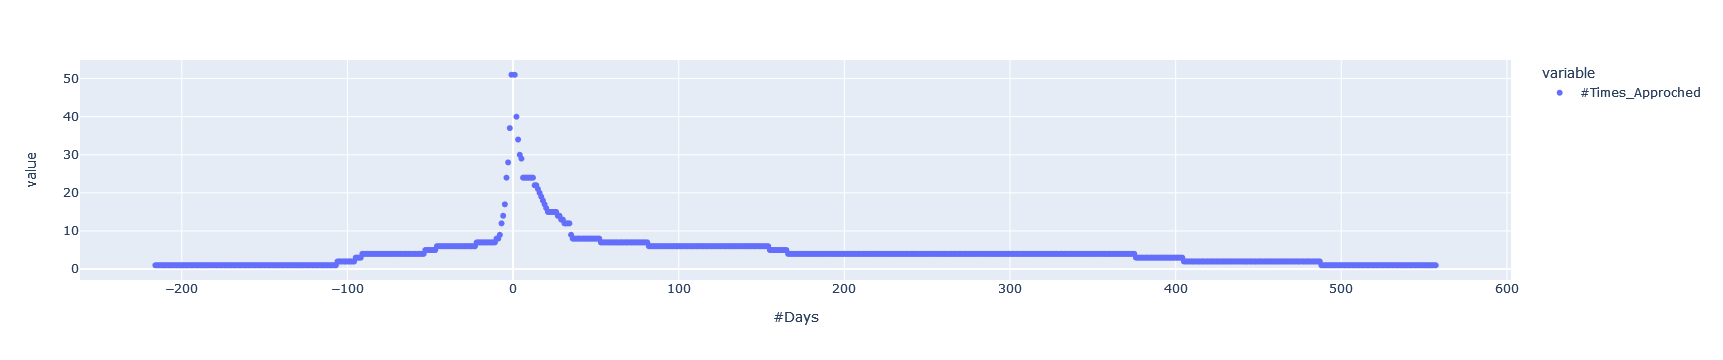

In [21]:
fig=px.scatter(df2)
fig.show()

In [22]:
################ Segrigated Main Stage 2 DF(df2) to two df's .One for when price crossed up and traded above, and other one when price crossed below and traded below  
df2_up=df2.loc[df2.index>0]
df2_down=df2.loc[df2.index<0]
df2_down=df2_down.iloc[::-1]

In [23]:
df2_up.head(),df2_down.head()

(       #Times_Approched
 #Days                  
 1.0                  51
 2.0                  40
 3.0                  34
 4.0                  30
 5.0                  29,
        #Times_Approched
 #Days                  
 -1.0                 51
 -2.0                 37
 -3.0                 28
 -4.0                 24
 -5.0                 17)

In [24]:
########This Section will merge the up and down df's into one and will add coluns acc to up days and down days .
df2_up_temp=df2_up.copy()
df2_up_temp.reset_index(inplace=True)
df2_up_temp.rename(columns={'#Times_Approched':'#Times_Approched_UP'},inplace=True)

df2_down_temp=df2_down.copy()
df2_down_temp.reset_index(inplace=True)
df2_down_temp['#Days']=df2_down_temp['#Days'].abs()
df2_down_temp.rename(columns={'#Times_Approched':'#Times_Approched_DOWN'},inplace=True)

df2_tmp=df2_up_temp.merge(df2_down_temp,on='#Days',how='outer')
df2_tmp.replace(to_replace=np.nan,value=0,inplace=True)

df2_tmp=df2_tmp.astype(int)

df2_tmp.set_index('#Days',inplace=True)

In [25]:
df2_tmp

#Times_Approched_UP  #Times_Approched_DOWN
#Days                                            
1                       51                     51
2                       40                     37
3                       34                     28
4                       30                     24
5                       29                     17
...                    ...                    ...
553                      1                      0
554                      1                      0
555                      1                      0
556                      1                      0
557                      1                      0

[557 rows x 2 columns]

## 

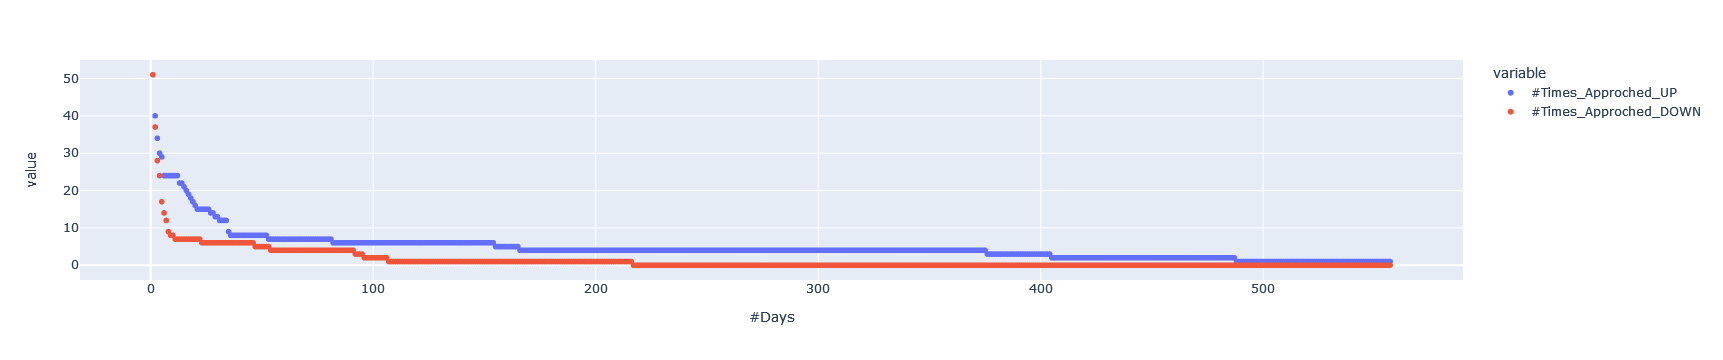

In [26]:
### Shows comparison of how many days reached  when in up move  vs down move from MA 
fig=px.scatter(df2_tmp)
fig.show()

In [75]:
### Will calculate % Chances to reach up to specfic number of days during up move or down move 
df2_tmp['%Chance_toApproched_UP']=(df2_tmp['#Times_Approched_UP']/df2_tmp['#Times_Approched_UP'].max())*100
df2_tmp['%Crossed_UP']=(df2_tmp['#Times_Approched_UP']/df2_tmp['#Times_Approched_UP'].shift(1))*100
# df2_tmp['%Crossed_UP_t']=(1-(df2_tmp['#Times_Approched_UP']/df2_tmp['#Times_Approched_UP'].shift(1)))*100


df2_tmp['%Chance_toApproched_DOWN']=(df2_tmp['#Times_Approched_DOWN']/df2_tmp['#Times_Approched_DOWN'].max())*100
df2_tmp['%Crossed_DOWN']=(df2_tmp['#Times_Approched_DOWN']/df2_tmp['#Times_Approched_DOWN'].shift(1))*100
# df2_tmp['%Crossed_DOWN_t']=(1-(df2_tmp['#Times_Approched_DOWN']/df2_tmp['#Times_Approched_DOWN'].shift(1)))*100



In [76]:
df2_tmp[:10]

#Times_Approched_UP  #Times_Approched_DOWN  %Chance_toApproched_UP  \
#Days                                                                       
1                       51                     51              100.000000   
2                       40                     37               78.431373   
3                       34                     28               66.666667   
4                       30                     24               58.823529   
5                       29                     17               56.862745   
6                       24                     14               47.058824   
7                       24                     12               47.058824   
8                       24                      9               47.058824   
9                       24                      8               47.058824   
10                      24                      8               47.058824   

       %Chance_toApproched_DOWN  %Crossed_UP  %Crossed_UP_t  %Crossed_UP_t1  \
#Days                                                                         
1                    100.000000          NaN            NaN             NaN   
2                     72.549020    78.431373      21.568627       21.568627   
3                     54.901961    85.000000      15.000000       11.764706   
4                     47.058824    88.235294      11.764706        7.843137   
5                     33.333333    96.666667       3.333333        1.960784   
6                     27.450980    82.758621      17.241379        9.803922   
7                     23.529412   100.000000       0.000000        0.000000   
8                     17.647059   100.000000       0.000000        0.000000   
9                     15.686275   100.000000       0.000000        0.000000   
10                    15.686275   100.000000       0.000000        0.000000   

       %Crossed_DOWN  %Crossed_DOWN_t  %Crossed_DOWN_t1  
#Days                                                    
1                NaN              NaN               NaN  
2          72.549020        27.450980         27.450980  
3          75.675676        24.324324         17.647059  
4          85.714286        14.285714          7.843137  
5          70.833333        29.166667         13.725490  
6          82.352941        17.647059          5.882353  
7          85.714286        14.285714          3.921569  
8          75.000000        25.000000          5.882353  
9          88.888889        11.111111          1.960784  
10        100.000000         0.000000          0.000000

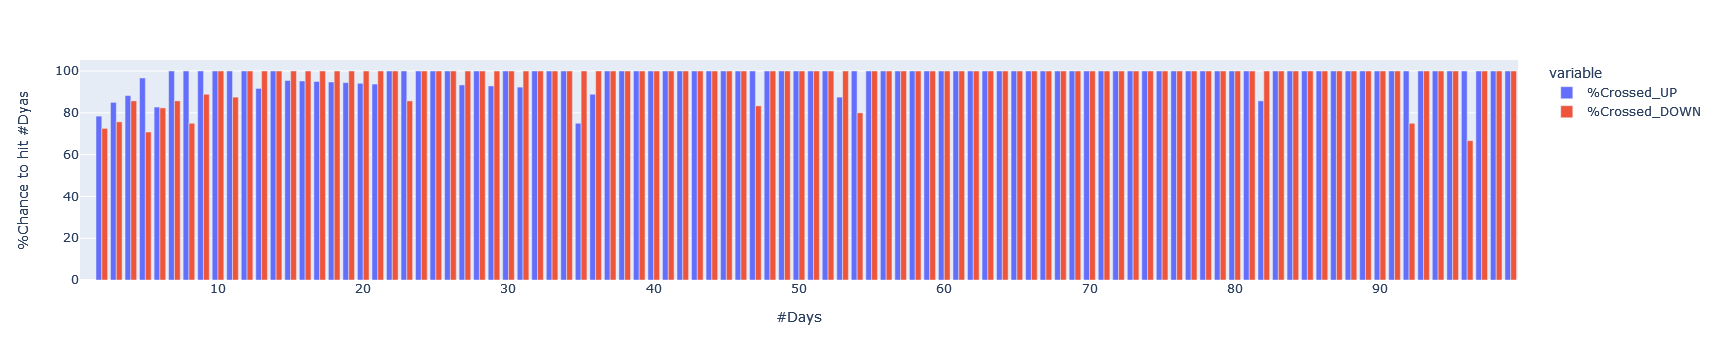

In [77]:
fig=px.bar(df2_tmp.loc[df2_tmp.index<100][['%Crossed_UP','%Crossed_DOWN']],barmode='group',labels={'value':'%Chance to hit #Dyas'})
fig.show()

In [78]:
# fig=px.bar(df2_tmp.loc[df2_tmp.index<22][['%Crossed_UP_t','%Crossed_DOWN_t']],barmode='group',labels={'value':'%Chance to hit #Dyas'})
# fig.show()

In [91]:
##### Checking how many days it takes up or down side when price crossed up or down and more then 85% chances that it will continue in same direction.
## Just hange the % to check if you want it more consistant .but best to keep above 85 .
min_days_up=df2_tmp.loc[df2_tmp['%Crossed_UP']>=85][:1].index[0]
min_days_down=df2_tmp.loc[df2_tmp['%Crossed_DOWN']>=85][:1].index[0]
print(f"when crossed above ,wait for {min_days_up} days. \nwhen crossed below ,wait for {min_days_down} days")

when crossed above ,wait for 3 days. 
when crossed below ,wait for 4 days


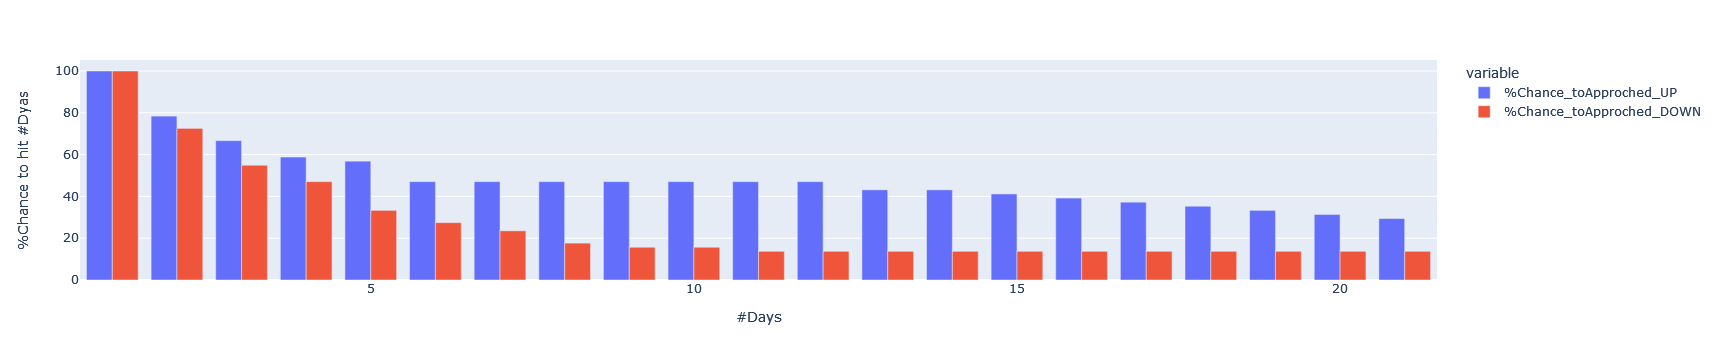

In [29]:

fig=px.bar(df2_tmp.loc[df2_tmp.index<22][['%Chance_toApproched_UP','%Chance_toApproched_DOWN']],barmode='group',labels={'value':'%Chance to hit #Dyas'})
fig.show()

# #################################END of Stage 2################################

# Stage 3
## Find % gain w.r.t #Days when crossing Above or Down 

In [93]:
## Taking mean of % change of price when crossed up or down for specfic days  
data1=df.groupby(df['RWEMA_252_movement'])['RWEMA_252_price%movement'].mean()

In [94]:
df3=data1.to_frame()
df3.reset_index(inplace=True)
df3.rename(columns={'RWEMA_252_movement':'#Days','RWEMA_252_price%movement':'% Average Price Move'},inplace=True)
df3.set_index('#Days',inplace=True)

In [101]:
####### Genric Information 
print(f"maximum number of days traded downside is {abs(df3.head(1).index[0])}")
print(f"maximum number of days traded upside is {abs(df3.tail(1).index[0])}")
df3.loc[df3.index>0].head(),df3.loc[df3.index<0].tail()
print (f"price moved {round(((abs(df3.tail(1).index[0])-abs(df3.head(1).index[0]))/(df3.index.max())*100),2)} % more days towards up side compare to downside")

maximum number of days traded downside is 216.0
maximum number of days traded upside is 557.0
price moved 61.22 % more days towards up side compare to downside


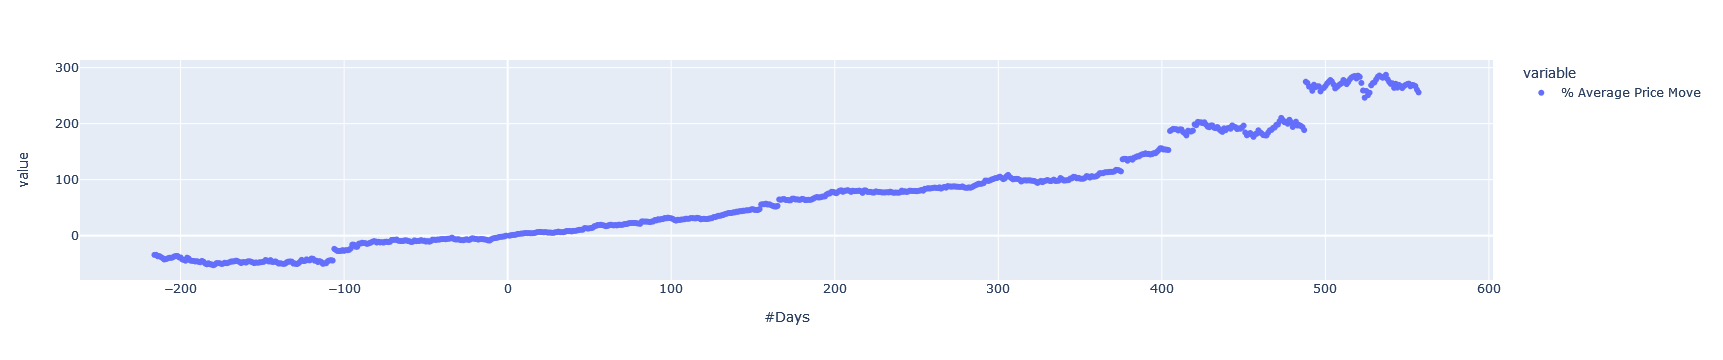

In [102]:
fig=px.scatter(df3)
fig.show()

In [34]:
################ Segrigated Main Stage 3 DF(df3) to two df's .One for when price crossed up and traded above, and other one when price crossed below and traded below  
df3_up=df3.loc[df3.index>0]
df3_down=df3.loc[df3.index<0]
df3_down=df3_down.iloc[::-1]

In [35]:
df3_up

%Price Move
#Days             
1.0       0.000000
2.0       0.786001
3.0       1.235250
4.0       1.489386
5.0       1.692023
...            ...
553.0   269.178023
554.0   268.609737
555.0   267.116195
556.0   260.524799
557.0   255.816663

[557 rows x 1 columns]

In [109]:
########This Section will merge the up and down df's into one and will add coluns acc to up days and down days .
df3_up_temp=df3_up.copy()
df3_up_temp.reset_index(inplace=True)
df3_up_temp.rename(columns={'%Price Move':'%Avg Price Move UP'},inplace=True)

df3_down_temp=df3_down.copy()
df3_down_temp.reset_index(inplace=True)
df3_down_temp['#Days']=df3_down_temp['#Days'].abs()
df3_down_temp.rename(columns={'%Price Move':'%Avg Price Move DOWN'},inplace=True)

df3_tmp=df3_up_temp.merge(df3_down_temp,on='#Days',how='outer')
df3_tmp.replace(to_replace=np.nan,value=0,inplace=True)

# df2_tmp=df2_tmp.astype(int)

df3_tmp.set_index('#Days',inplace=True)

In [108]:
df3_tmp

% Avg Price Move UP  %Avg Price Move DOWN
#Days                                           
1.0               0.000000              0.000000
2.0               0.786001             -1.205285
3.0               1.235250             -1.736601
4.0               1.489386             -1.937377
5.0               1.692023             -2.154337
...                    ...                   ...
553.0           269.178023              0.000000
554.0           268.609737              0.000000
555.0           267.116195              0.000000
556.0           260.524799              0.000000
557.0           255.816663              0.000000

[557 rows x 2 columns]

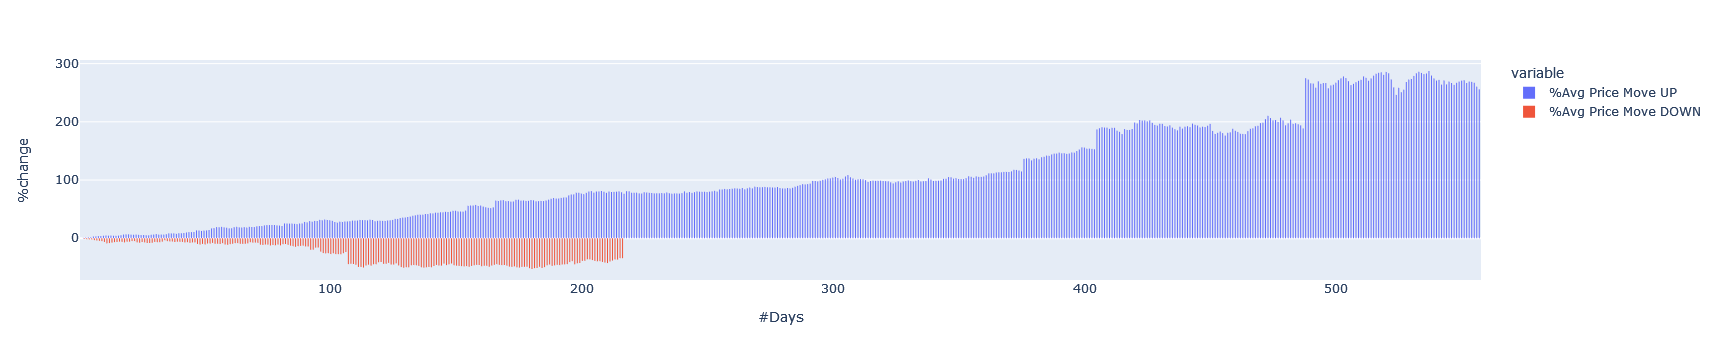

In [110]:
### Shows comparison of how many days reached  when in up move  vs down move from MA 
fig=px.bar(df3_tmp.loc[df3_tmp.index<590][['%Avg Price Move UP','%Avg Price Move DOWN']],barmode='group',labels={'value':'%change '})
fig.update_traces(dict(marker_line_width=0))
fig.show()

In [39]:
np.where(df['RWEMA_252_movement']==df['RWEMA_252_movement'].max())
df[883-556:884]


Open        High         Low       Close   Adj Close  \
Date                                                                     
2009-05-15  156.000000  163.712494  156.000000  161.012497  126.449821   
2009-05-18  191.649994  197.899994  173.750000  185.962494  146.044067   
2009-05-19  187.500000  187.500000  163.899994  167.437500  131.495651   
2009-05-20  167.500000  175.487503  165.750000  169.162506  132.850311   
2009-05-21  167.500000  171.250000  161.000000  161.862503  127.117355   
...                ...         ...         ...         ...         ...   
2011-07-29  566.500000  571.000000  560.825012  568.500000  466.824951   
2011-08-01  571.200012  574.950012  562.549988  567.625000  466.106354   
2011-08-02  565.250000  567.000000  561.125000  565.325012  464.217773   
2011-08-03  560.000000  562.849976  547.674988  555.174988  455.882965   
2011-08-04  555.025024  559.750000  545.549988  547.924988  449.929535   

              Volume  pct_change   RWEMA_252  RWEMA_252_movement  \
Date                                                               
2009-05-15  10942472    3.912629  122.659147                 1.0   
2009-05-18     73380   15.495669  122.685193                 2.0   
2009-05-19  13015576   -9.961662  122.615287                 3.0   
2009-05-20   8507664    1.030194  122.544084                 4.0   
2009-05-21   4459324   -4.315350  122.444429                 5.0   
...              ...         ...         ...                 ...   
2011-07-29   1719138    0.659578  447.900274               553.0   
2011-08-01   1982346   -0.153933  448.262046               554.0   
2011-08-02   2025292   -0.405182  448.611940               555.0   
2011-08-03   3064246   -1.795452  448.914014               556.0   
2011-08-04   3049294   -1.305912  449.143271               557.0   

            RWEMA_252_price%movement  check  crossover  
Date                                                    
2009-05-15                  0.000000      1          1  
2009-05-18                 15.495669      1          0  
2009-05-19                  3.990381      1          0  
2009-05-20                  5.061684      1          0  
2009-05-21                  0.527904      1          0  
...                              ...    ...        ...  
2011-07-29                269.178023      1          0  
2011-08-01                268.609737      1          0  
2011-08-02                267.116195      1          0  
2011-08-03                260.524799      1          0  
2011-08-04                255.816663      1          0  

[557 rows x 12 columns]

In [40]:
((450-126.4)/126.4)*100

256.0126582278481

In [41]:
### Will calculate % Chances to reach up to specfic number of days during up move or down move 
df3_tmp['%Chance_UP']=(df3_tmp['%Price Move UP']/df3_tmp['%Price Move UP'].max())*100
df3_tmp['%Chance_DOWN']=abs((df3_tmp['%Price Move DOWN']/df3_tmp['%Price Move DOWN'].min())*100)


In [42]:
df3_tmp

%Price Move UP  %Price Move DOWN  %Chance_UP  %Chance_DOWN
#Days                                                            
1.0          0.000000          0.000000    0.000000      0.000000
2.0          0.786001         -1.205285    0.273594      2.281276
3.0          1.235250         -1.736601    0.429971      3.286913
4.0          1.489386         -1.937377    0.518431      3.666928
5.0          1.692023         -2.154337    0.588966      4.077573
...               ...               ...         ...           ...
553.0      269.178023          0.000000   93.696507      0.000000
554.0      268.609737          0.000000   93.498696      0.000000
555.0      267.116195          0.000000   92.978818      0.000000
556.0      260.524799          0.000000   90.684460      0.000000
557.0      255.816663          0.000000   89.045634      0.000000

[557 rows x 4 columns]

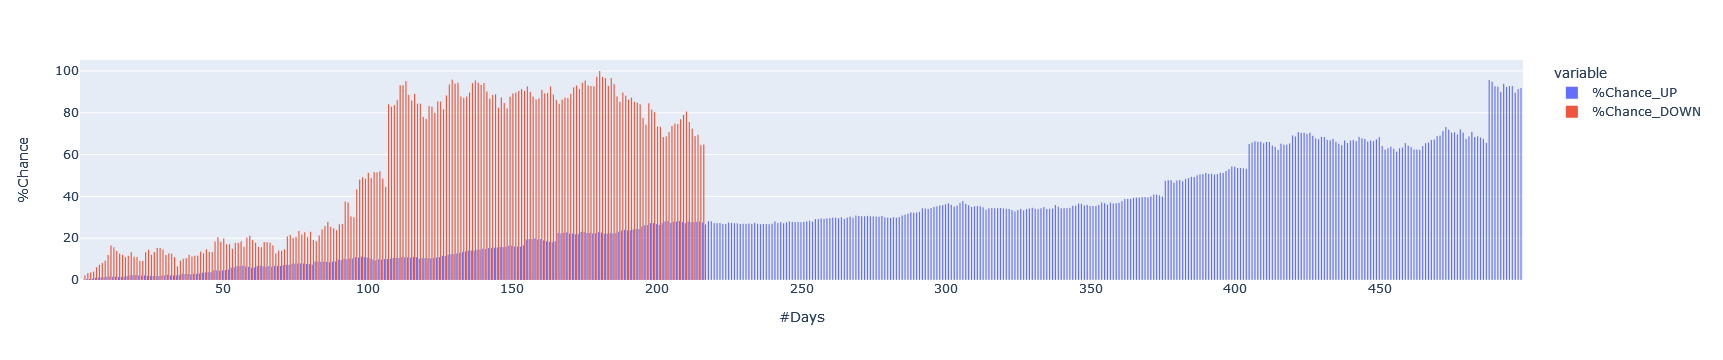

In [43]:

fig=px.bar(df3_tmp.loc[df3_tmp.index<500][['%Chance_UP','%Chance_DOWN']],barmode='group',labels={'value':'%Chance '})
fig.update_traces(dict(marker_line_width=0))
fig.show()

## ##################End of Stage 3###########################

# Stage -4 Backtest 

In [44]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2008-01-07   250.000000   252.199997   243.125000   243.899994   186.840485   
2008-01-08   245.000000   248.000000   242.324997   246.962494   189.186523   
2008-01-09   248.699997   251.500000   247.475006   249.074997   190.804825   
2008-01-10   249.500000   252.375000   240.500000   245.412506   187.999100   
2008-01-11   228.837494   251.000000   228.837494   247.437500   189.550385   
...                 ...          ...          ...          ...          ...   
2022-01-31  3749.000000  3758.000000  3721.399902  3736.250000  3736.250000   
2022-02-01  3770.000000  3808.000000  3736.399902  3800.649902  3800.649902   
2022-02-02  3827.899902  3864.000000  3800.649902  3856.199951  3856.199951   
2022-02-03  3851.000000  3882.500000  3816.050049  3824.600098  3824.600098   
2022-02-04  3815.300049  3824.699951  3769.000000  3814.899902  3814.899902   

             Volume  pct_change    RWEMA_252  RWEMA_252_movement  \
Date                                                               
2008-01-07  3647344   -2.944662   213.777025                -1.0   
2008-01-08  3207732    1.255637   213.556674                -2.0   
2008-01-09  2450128    0.855400   213.356547                -3.0   
2008-01-10  3342376   -1.470469   213.137898                -4.0   
2008-01-11  2149188    0.825155   212.938219                -5.0   
...             ...         ...          ...                 ...   
2022-01-31  2739393    1.252014  3457.973900               400.0   
2022-02-01  2105169    1.723651  3460.587225               401.0   
2022-02-02  1984212    1.461593  3463.607400               402.0   
2022-02-03  1960538   -0.819456  3466.564350               403.0   
2022-02-04  2306676   -0.253626  3469.642794               404.0   

            RWEMA_252_price%movement  check  crossover  
Date                                                    
2008-01-07                  0.000000     -1          0  
2008-01-08                  1.255637     -1          0  
2008-01-09                  2.121778     -1          0  
2008-01-10                  0.620109     -1          0  
2008-01-11                  1.450382     -1          0  
...                              ...    ...        ...  
2022-01-31                 79.739323      1          0  
2022-02-01                 82.837401      1          0  
2022-02-02                 85.509741      1          0  
2022-02-03                 83.989571      1          0  
2022-02-04                 83.522924      1          0  

[3470 rows x 12 columns]

In [45]:
def backtest(start,end,init_df,trade):    
    bt=pd.DataFrame({'StartDate':start,'EndDate':end})
    bt.replace(to_replace=np.nan,value=0,inplace=True)
    
    dataframes=[]
    pc_=[]
    
    # for index, row in bt.iterrows():
    #     init_df_tmp=init_df.iloc[np.where((init_df.index>=row['StartDate'])&(init_df.index<=row['EndDate']))]
    #     # init_df=init_df.reset_index()
    if trade=='long':
        for index in bt.index:
            init_df_tmp=(init_df.loc[(init_df.index>=bt['StartDate'][index]) & (init_df.index<=bt['EndDate'][index])]).copy()
            # init_df=init_df.reset_index()

            pos=0
            num=0
            percentchange=[]
            day_count=0
            init_df_tmp['pos_days']=0
            init_df_tmp['s_daily_change']=0.0
            s_st=[]
            trigger_p=[]
            lastpc=[0,]
            #### price at time of start date of this stratgy
            u_st=init_df_tmp['Adj Close'][0]
            for i in init_df_tmp.index:
                CP=init_df_tmp['Adj Close'][i]
                # init_df_tmp.at[i,'u_daily_Return']=((CP/u_st)-1)*100
                init_df_tmp.at[i,'u_daily_Return']=init_df_tmp['pct_change'][i]
                # print(f"current price {CP}")
                #############Long Position#####################
                ## Buy Condition
                if init_df_tmp['Adj Close'][i]> init_df_tmp['RWEMA_252'][i]:                
                    if(pos==0):
                        print("Long Buy Triggred")
                        bp=CP
                        pos=1
                        print("Buying now at "+str(bp))
                        init_df_tmp.at[i,'pos_days']=day_count
                        if not s_st:
                            ## 
                            s_st.append(bp)

                    else:
                        day_count+=1
                        init_df_tmp.at[i,'pos_days']=day_count
                        init_df_tmp['s_daily_change'][i]=init_df_tmp['pct_change'][i]
                        
                ## Sell Condition       
                elif init_df_tmp['Adj Close'][i]< init_df_tmp['RWEMA_252'][i]:                
                    if(pos==1):
                        print("Short Buying Triggred")
                        day_count=0
                        pos=0
                        sp=CP
                        print("Existing now at "+str(sp))
                        pc=(sp/bp-1)*100
                        percentchange.append(pc)
                        init_df_tmp.at[i,'pos_days']=day_count


                if(num==init_df_tmp["Adj Close"].count()-1 and pos==1):
                    pos=0
                    sp=CP
                    day_count=0
                    print("Existing now at "+str(sp))
                    pc=(sp/bp-1)*100
                    percentchange.append(pc)
                    init_df_tmp.at[i,'pos_days']=day_count


                num+=1    
            pc_.append(percentchange)

            #################################for Performance Matrix############
            gains=0
            ng=0
            losses=0
            nl=0
            totalR=1

            for i in percentchange:
                if(i>0):
                    gains+=i
                    ng+=1
                else:
                    losses+=i
                    nl+=1
                totalR=totalR*((i/100)+1)

            totalR=round((totalR-1)*100,2)

            if(ng>0):
                avgGain=gains/ng
                maxR=max(percentchange)
            else:
                avgGain=0
                maxR=0

            if(nl>0):
                avgLoss=losses/nl
                maxL=min(percentchange)
                ratio=-avgGain/avgLoss
            else:
                avgLoss=0
                maxL=0
                ratio=999

            if(ng>0 or nl>0):
                battingAvg=(ng/(ng+nl))*100
            else:
                battingAvg=0

            # print()
            # print("Results for Sample size: "+str(ng+nl)+" trades")
            # # print("EMAs used: "+str(emasUsed))
            # print("Batting Avg: "+ str(battingAvg))
            # print("Gain/loss ratio: "+ ratio)
            # print("Average Gain: "+ str(avgGain))
            # print("Average Loss: "+ str(avgLoss))
            # print("Max Return: "+ maxR)
            # print("Max Loss: "+ maxL)
            # print("Total return over "+str(ng+nl)+ " trades: "+ str(totalR)+"%" )


            bt.at[index,'#Trades']=ng+nl
            bt.at[index,'Win avg']=round(battingAvg,2)
            bt.at[index,'#Wins']=ng
            bt.at[index,'#loss']=nl
            bt.at[index,'Gain/loss ratio']=round(ratio,2)
            bt.at[index,'Average Gain %']=round(avgGain,2)
            bt.at[index,'Average Loss %']=round(avgLoss,2)
            bt.at[index,'Max Return %']=round(maxR,2)
            bt.at[index,'Max Loss %']=round(maxL,2)
            bt.at[index,'Total return %']=round(totalR,2)

            dataframes.append(init_df_tmp)
            
    if trade=='short':
        for index in bt.index:
            init_df_tmp=(init_df.loc[(init_df.index>=bt['StartDate'][index]) & (init_df.index<=bt['EndDate'][index])]).copy()
            # init_df=init_df.reset_index()

            pos=0
            num=0
            percentchange=[]
            day_count=0
            init_df_tmp['pos_days']=0
            init_df_tmp['s_daily_Return']=0.0
            s_st=[]
            #### price at time of start date of this stratgy
            u_st=init_df_tmp['Adj Close'][0]
            for i in init_df_tmp.index:
                CP=init_df_tmp['Adj Close'][i]
                init_df_tmp.at[i,'u_daily_Return']=((CP/u_st)-1)*100
                # print(f"current price {CP}")
                #############Short Position#####################
                ## Short Condition
                if init_df_tmp['Adj Close'][i]< init_df_tmp['RWEMA_252'][i]:                
                    if(pos==0):
                        print("Short position Triggred")
                        sp=CP
                        pos=1
                        print("Shorting now at "+str(sp))
                        init_df_tmp.at[i,'pos_days']=day_count
                        if not s_st:
                            s_st.append(sp)
                        init_df_tmp.at[i,'s_daily_Return']=(((CP/s_st[0])-1)*100)*(-1)
                    else:
                        day_count+=1
                        init_df_tmp.at[i,'pos_days']=day_count
                        init_df_tmp.at[i,'s_daily_Return']=(((CP/s_st[0])-1)*100)*(-1)

                ## Cover Condition       
                elif init_df_tmp['Adj Close'][i]> init_df_tmp['RWEMA_252'][i]:                
                    if(pos==1):
                        print("Short Covering Triggred")
                        day_count=0
                        pos=0
                        bp=CP
                        print("Existing now at "+str(bp))
                        pc=((bp/sp-1)*100)*(-1)
                        percentchange.append(pc)
                        init_df_tmp.at[i,'pos_days']=day_count

                    if s_st: 
                        init_df_tmp.at[i,'s_daily_Return']=init_df_tmp['s_daily_Return'].shift(1)[i]
                    else:
                        init_df_tmp.at[i,'s_daily_Return']=0

                if(num==init_df_tmp["Adj Close"].count()-1 and pos==1):
                    pos=0
                    bp=CP
                    day_count=0
                    print("Existing now at "+str(bp))
                    pc=((bp/sp-1)*100)*(-1)
                    percentchange.append(pc)
                    init_df_tmp.at[i,'pos_days']=day_count

                num+=1    
            pc_.append(percentchange)

            #################################for Performance Matrix############
            gains=0
            ng=0
            losses=0
            nl=0
            totalR=1

            for i in percentchange:
                if(i>0):
                    gains+=i
                    ng+=1
                else:
                    losses+=i
                    nl+=1
                totalR=totalR*((i/100)+1)

            totalR=round((totalR-1)*100,2)

            if(ng>0):
                avgGain=gains/ng
                maxR=max(percentchange)
            else:
                avgGain=0
                maxR=0

            if(nl>0):
                avgLoss=losses/nl
                maxL=min(percentchange)
                ratio=-avgGain/avgLoss
            else:
                avgLoss=0
                maxL=0
                ratio=999

            if(ng>0 or nl>0):
                battingAvg=(ng/(ng+nl))*100
            else:
                battingAvg=0

            # print()
            # print("Results for Sample size: "+str(ng+nl)+" trades")
            # # print("EMAs used: "+str(emasUsed))
            # print("Batting Avg: "+ str(battingAvg))
            # print("Gain/loss ratio: "+ ratio)
            # print("Average Gain: "+ str(avgGain))
            # print("Average Loss: "+ str(avgLoss))
            # print("Max Return: "+ maxR)
            # print("Max Loss: "+ maxL)
            # print("Total return over "+str(ng+nl)+ " trades: "+ str(totalR)+"%" )


            bt.at[index,'#Trades']=ng+nl
            bt.at[index,'Win avg']=round(battingAvg,2)
            bt.at[index,'#Wins']=ng
            bt.at[index,'#loss']=nl
            bt.at[index,'Gain/loss ratio']=round(ratio,2)
            bt.at[index,'Average Gain %']=round(avgGain,2)
            bt.at[index,'Average Loss %']=round(avgLoss,2)
            bt.at[index,'Max Return %']=round(maxR,2)
            bt.at[index,'Max Loss %']=round(maxL,2)
            bt.at[index,'Total return %']=round(totalR,2)

            dataframes.append(init_df_tmp)
        
        
        
            
   ### at this moment no matrix added into bt
    # print(f"stratgy start date{s_st}")
    # return pc_, init_df
    return bt, dataframes, pc_
    

In [46]:
def backtest_old(start,end,init_df):    
    bt=pd.DataFrame({'StartDate':start,'EndDate':end})
    bt.replace(to_replace=np.nan,value=0,inplace=True)
    
    dataframes=[]
    pc_=[]
    
    # for index, row in bt.iterrows():
    #     init_df_tmp=init_df.iloc[np.where((init_df.index>=row['StartDate'])&(init_df.index<=row['EndDate']))]
    #     # init_df=init_df.reset_index()
    
    for index in bt.index:
        init_df_tmp=(init_df.loc[(init_df.index>=bt['StartDate'][index]) & (init_df.index<=bt['EndDate'][index])]).copy()
        # init_df=init_df.reset_index()
        
        pos=0
        num=0
        percentchange=[]
        day_count=0
        init_df_tmp['pos_days']=0
        init_df_tmp['s_daily_Return']=0.0
        s_st=[]
        #### price at time of start date of this stratgy
        u_st=init_df_tmp['Adj Close'][0]
        for i in init_df_tmp.index:
            CP=init_df_tmp['Adj Close'][i]
            init_df_tmp.at[i,'u_daily_Return']=((CP/u_st)-1)*100
            # print(f"current price {CP}")
            #############Long Position#####################
            ## Buy Condition
            if init_df_tmp['Adj Close'][i]> init_df_tmp['RWEMA_252'][i]:                
                if(pos==0):
                    print("Long Buy Triggred")
                    bp=CP
                    pos=1
                    print("Buying now at "+str(bp))
                    init_df_tmp.at[i,'pos_days']=day_count
                    if not s_st:
                        s_st.append(bp)
                    init_df_tmp.at[i,'s_daily_Return']=((CP/s_st[0])-1)*100
                else:
                    day_count+=1
                    init_df_tmp.at[i,'pos_days']=day_count
                    init_df_tmp.at[i,'s_daily_Return']=((CP/s_st[0])-1)*100
                    
            ## Sell Condition       
            elif init_df_tmp['Adj Close'][i]< init_df_tmp['RWEMA_252'][i]:                
                if(pos==1):
                    print("Short Buying Triggred")
                    day_count=0
                    pos=0
                    sp=CP
                    print("Existing now at "+str(sp))
                    pc=(sp/bp-1)*100
                    percentchange.append(pc)
                    init_df_tmp.at[i,'pos_days']=day_count
                
                if s_st: 
                    init_df_tmp.at[i,'s_daily_Return']=init_df_tmp['s_daily_Return'].shift(1)[i]
                else:
                    init_df_tmp.at[i,'s_daily_Return']=0
                   
            if(num==init_df_tmp["Adj Close"].count()-1 and pos==1):
                pos=0
                sp=CP
                day_count=0
                print("Existing now at "+str(sp))
                pc=(sp/bp-1)*100
                percentchange.append(pc)
                init_df_tmp.at[i,'pos_days']=day_count

            num+=1    
        pc_.append(percentchange)
        
        #################################for Performance Matrix############
        gains=0
        ng=0
        losses=0
        nl=0
        totalR=1

        for i in percentchange:
            if(i>0):
                gains+=i
                ng+=1
            else:
                losses+=i
                nl+=1
            totalR=totalR*((i/100)+1)

        totalR=round((totalR-1)*100,2)

        if(ng>0):
            avgGain=gains/ng
            maxR=max(percentchange)
        else:
            avgGain=0
            maxR=0

        if(nl>0):
            avgLoss=losses/nl
            maxL=min(percentchange)
            ratio=-avgGain/avgLoss
        else:
            avgLoss=0
            maxL=0
            ratio=999

        if(ng>0 or nl>0):
            battingAvg=(ng/(ng+nl))*100
        else:
            battingAvg=0

        # print()
        # print("Results for Sample size: "+str(ng+nl)+" trades")
        # # print("EMAs used: "+str(emasUsed))
        # print("Batting Avg: "+ str(battingAvg))
        # print("Gain/loss ratio: "+ ratio)
        # print("Average Gain: "+ str(avgGain))
        # print("Average Loss: "+ str(avgLoss))
        # print("Max Return: "+ maxR)
        # print("Max Loss: "+ maxL)
        # print("Total return over "+str(ng+nl)+ " trades: "+ str(totalR)+"%" )

        
        bt.at[index,'#Trades']=ng+nl
        bt.at[index,'Win avg']=round(battingAvg,2)
        bt.at[index,'#Wins']=ng
        bt.at[index,'#loss']=nl
        bt.at[index,'Gain/loss ratio']=round(ratio,2)
        bt.at[index,'Average Gain %']=round(avgGain,2)
        bt.at[index,'Average Loss %']=round(avgLoss,2)
        bt.at[index,'Max Return %']=round(maxR,2)
        bt.at[index,'Max Loss %']=round(maxL,2)
        bt.at[index,'Total return %']=round(totalR,2)
        
        dataframes.append(init_df_tmp)
        
        
        
            
   ### at this moment no matrix added into bt
    # print(f"stratgy start date{s_st}")
    # return pc_, init_df
    return bt, dataframes
    

In [47]:
###########Full
# start and end must be same length
start=['2008-01-07']
end=['2022-02-01']

# pc,init_df=backtest(start=start,end=end,init_df=df)
result_matrix_f,init_df_matrix_f,pc=backtest(start=start,end=end,init_df=df,trade='long')

Long Buy Triggred
Buying now at 194.05064392089844
Short Buying Triggred
Existing now at 187.45700073242188
Long Buy Triggred
Buying now at 188.74502563476562
Short Buying Triggred
Existing now at 185.7365264892578
Long Buy Triggred
Buying now at 130.83792114257812
Short Buying Triggred
Existing now at 120.79534912109375
Long Buy Triggred
Buying now at 125.87064361572266
Short Buying Triggred
Existing now at 122.06170654296875
Long Buy Triggred
Buying now at 126.44982147216797


C:\Users\admin\AppData\Local\Temp/ipykernel_9128/2354391689.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Short Buying Triggred
Existing now at 434.36883544921875
Long Buy Triggred
Buying now at 465.69573974609375
Short Buying Triggred
Existing now at 424.3508605957031
Long Buy Triggred
Buying now at 452.3362121582031
Short Buying Triggred
Existing now at 447.3747863769531
Long Buy Triggred
Buying now at 459.2940673828125
Short Buying Triggred
Existing now at 448.5687561035156
Long Buy Triggred
Buying now at 456.7619934082031
Short Buying Triggred
Existing now at 454.51812744140625
Long Buy Triggred
Buying now at 457.7557373046875
Short Buying Triggred
Existing now at 463.2261657714844
Long Buy Triggred
Buying now at 468.5313720703125
Short Buying Triggred
Existing now at 441.0762939453125
Long Buy Triggred
Buying now at 493.0344543457031
Short Buying Triggred
Existing now at 516.5198974609375
Long Buy Triggred
Buying now at 518.899658203125
Short Buying Triggred
Existing now at 503.2855224609375
Long Buy Triggred
Buying now at 522.7197875976562
Short Buying Triggred
Existing now at 1029.2

In [48]:
result_matrix_f

StartDate     EndDate  #Trades  Win avg  #Wins  #loss  Gain/loss ratio  \
0  2008-01-07  2022-02-01     51.0    27.45   14.0   37.0            17.02   

   Average Gain %  Average Loss %  Max Return %  Max Loss %  Total return %  
0           35.51           -2.09        243.51       -8.88          955.35

In [49]:
returns=init_df_matrix_f[0]['Adj Close'].pct_change()*100

In [50]:
cmr=((1+(returns/100)).cumprod()-1)*100

In [51]:
cmr

Date
2008-01-07            NaN
2008-01-08       1.255637
2008-01-09       2.121778
2008-01-10       0.620109
2008-01-11       1.450382
                 ...     
2022-01-25    1917.710407
2022-01-27    1853.136660
2022-01-28    1874.973495
2022-01-31    1899.700444
2022-02-01    1934.168296
Name: Adj Close, Length: 3467, dtype: float64

In [52]:
returns

Date
2008-01-07         NaN
2008-01-08    1.255637
2008-01-09    0.855400
2008-01-10   -1.470469
2008-01-11    0.825155
                ...   
2022-01-25   -0.038453
2022-01-27   -3.200348
2022-01-28    1.118039
2022-01-31    1.252014
2022-02-01    1.723651
Name: Adj Close, Length: 3467, dtype: float64

In [53]:
((1+(init_df_matrix_f[0]['u_daily_Return']/100)).cumprod()-1)*100

Date
2008-01-07      -2.944662
2008-01-08      -1.725999
2008-01-09      -0.885364
2008-01-10      -2.342813
2008-01-11      -1.536990
                 ...     
2022-01-25    1858.295647
2022-01-27    1795.623379
2022-01-28    1816.817193
2022-01-31    1840.816017
2022-02-01    1874.268907
Name: u_daily_Return, Length: 3467, dtype: float64

In [54]:
init_df_matrix_f=init_df_matrix_f[0]

In [55]:
init_df_matrix_f

Open         High          Low        Close    Adj Close  \
Date                                                                          
2008-01-07   250.000000   252.199997   243.125000   243.899994   186.840485   
2008-01-08   245.000000   248.000000   242.324997   246.962494   189.186523   
2008-01-09   248.699997   251.500000   247.475006   249.074997   190.804825   
2008-01-10   249.500000   252.375000   240.500000   245.412506   187.999100   
2008-01-11   228.837494   251.000000   228.837494   247.437500   189.550385   
...                 ...          ...          ...          ...          ...   
2022-01-25  3769.500000  3809.399902  3722.199951  3769.899902  3769.899902   
2022-01-27  3731.000000  3733.399902  3625.100098  3649.250000  3649.250000   
2022-01-28  3646.000000  3729.800049  3646.000000  3690.050049  3690.050049   
2022-01-31  3749.000000  3758.000000  3721.399902  3736.250000  3736.250000   
2022-02-01  3770.000000  3808.000000  3736.399902  3800.649902  3800.649902   

             Volume  pct_change    RWEMA_252  RWEMA_252_movement  \
Date                                                               
2008-01-07  3647344   -2.944662   213.777025                -1.0   
2008-01-08  3207732    1.255637   213.556674                -2.0   
2008-01-09  2450128    0.855400   213.356547                -3.0   
2008-01-10  3342376   -1.470469   213.137898                -4.0   
2008-01-11  2149188    0.825155   212.938219                -5.0   
...             ...         ...          ...                 ...   
2022-01-25  3330501   -0.038453  3452.159276               397.0   
2022-01-27  5718297   -3.200348  3453.806474               398.0   
2022-01-28  3143862    1.118039  3455.782571               399.0   
2022-01-31  2739393    1.252014  3457.973900               400.0   
2022-02-01  2105169    1.723651  3460.587225               401.0   

            RWEMA_252_price%movement  check  crossover  pos_days  \
Date                                                               
2008-01-07                  0.000000     -1          0         0   
2008-01-08                  1.255637     -1          0         0   
2008-01-09                  2.121778     -1          0         0   
2008-01-10                  0.620109     -1          0         0   
2008-01-11                  1.450382     -1          0         0   
...                              ...    ...        ...       ...   
2022-01-25                 81.358115      1          0       396   
2022-01-27                 75.554025      1          0       397   
2022-01-28                 77.516788      1          0       398   
2022-01-31                 79.739323      1          0       399   
2022-02-01                 82.837401      1          0         0   

            s_daily_change  u_daily_Return  
Date                                        
2008-01-07        0.000000       -2.944662  
2008-01-08        0.000000        1.255637  
2008-01-09        0.000000        0.855400  
2008-01-10        0.000000       -1.470469  
2008-01-11        0.000000        0.825155  
...                    ...             ...  
2022-01-25       -0.038453       -0.038453  
2022-01-27       -3.200348       -3.200348  
2022-01-28        1.118039        1.118039  
2022-01-31        1.252014        1.252014  
2022-02-01        1.723651        1.723651  

[3467 rows x 15 columns]

In [56]:
init_df_matrix_f['scr']=((1+(init_df_matrix_f['s_daily_change']/100)).cumprod()-1)*100

In [57]:
init_df_matrix_f['ucr']=((1+(init_df_matrix_f['u_daily_Return']/100)).cumprod()-1)*100

In [58]:
init_df_matrix_f.loc[init_df_matrix_f.index>='2010-09-10']

Open         High          Low        Close    Adj Close  \
Date                                                                          
2010-09-13   435.674988   444.500000   435.350006   439.875000   356.535034   
2010-09-14   441.500000   449.500000   440.149994   447.674988   362.857208   
2010-09-15   450.000000   459.700012   449.500000   457.399994   370.739685   
2010-09-16   454.000000   456.725006   432.250000   447.700012   362.877502   
2010-09-17   450.049988   459.375000   450.049988   456.899994   370.334412   
...                 ...          ...          ...          ...          ...   
2022-01-25  3769.500000  3809.399902  3722.199951  3769.899902  3769.899902   
2022-01-27  3731.000000  3733.399902  3625.100098  3649.250000  3649.250000   
2022-01-28  3646.000000  3729.800049  3646.000000  3690.050049  3690.050049   
2022-01-31  3749.000000  3758.000000  3721.399902  3736.250000  3736.250000   
2022-02-01  3770.000000  3808.000000  3736.399902  3800.649902  3800.649902   

             Volume  pct_change    RWEMA_252  RWEMA_252_movement  \
Date                                                               
2010-09-13  2349410    0.577356   306.372255               332.0   
2010-09-14  3071038    1.773227   306.945811               333.0   
2010-09-15  5560394    2.172336   307.549114               334.0   
2010-09-16  2334264   -2.120675   308.097342               335.0   
2010-09-17  3007978    2.054938   308.684854               336.0   
...             ...         ...          ...                 ...   
2022-01-25  3330501   -0.038453  3452.159276               397.0   
2022-01-27  5718297   -3.200348  3453.806474               398.0   
2022-01-28  3143862    1.118039  3455.782571               399.0   
2022-01-31  2739393    1.252014  3457.973900               400.0   
2022-02-01  2105169    1.723651  3460.587225               401.0   

            RWEMA_252_price%movement  check  crossover  pos_days  \
Date                                                               
2010-09-13                181.957720      1          0       331   
2010-09-14                186.957470      1          0       332   
2010-09-15                193.191149      1          0       333   
2010-09-16                186.973519      1          0       334   
2010-09-17                192.870648      1          0       335   
...                              ...    ...        ...       ...   
2022-01-25                 81.358115      1          0       396   
2022-01-27                 75.554025      1          0       397   
2022-01-28                 77.516788      1          0       398   
2022-01-31                 79.739323      1          0       399   
2022-02-01                 82.837401      1          0         0   

            s_daily_change  u_daily_Return          scr          ucr  
Date                                                                  
2010-09-13        0.577356        0.577356   160.188471    85.204123  
2010-09-14        1.773227        1.773227   164.802202    88.488212  
2010-09-15        2.172336        2.172336   170.554595    92.582809  
2010-09-16       -2.120675       -2.120675   164.817012    88.498754  
2010-09-17        2.054938        2.054938   170.258839    92.372287  
...                    ...             ...          ...          ...  
2022-01-25       -0.038453       -0.038453  2987.287897  1858.295647  
2022-01-27       -3.200348       -3.200348  2888.483952  1795.623379  
2022-01-28        1.118039        1.118039  2921.896377  1816.817193  
2022-01-31        1.252014        1.252014  2959.730949  1840.816017  
2022-02-01        1.723651        1.723651  3012.470025  1874.268907  

[2809 rows x 17 columns]

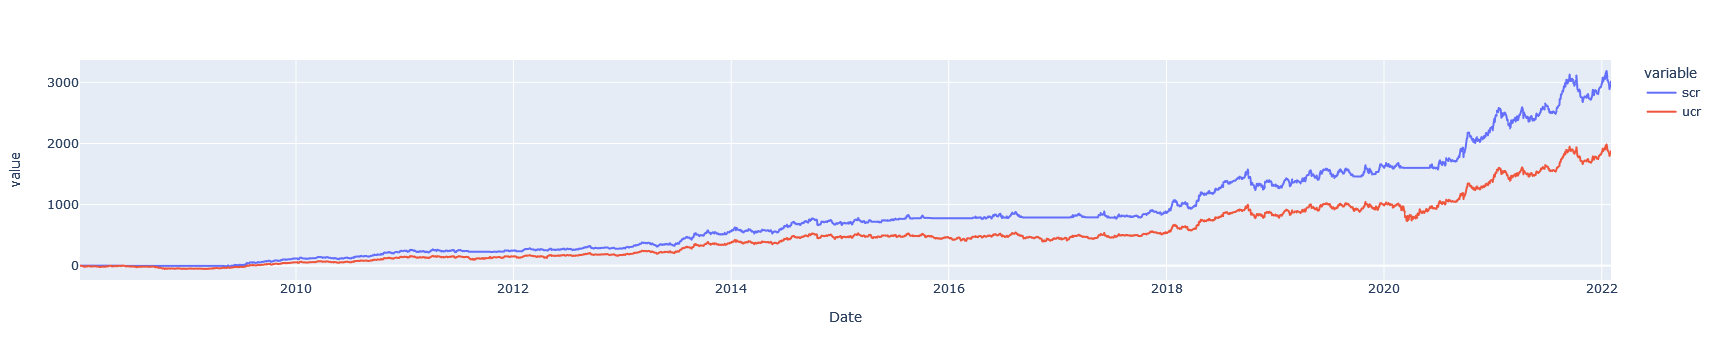

In [59]:
fig=px.line(init_df_matrix_f[['scr','ucr']],)
fig.show()

In [60]:
init_df_matrix_y[-3]

NameError: name 'init_df_matrix_y' is not defined

In [ ]:
###########incremental
# start and end must be same length
start=['2008-01-07','2010-01-01','2011-01-01','2012-01-01','2013-01-01','2014-01-01','2015-01-01','2016-01-01','2017-01-01','2018-01-01','2019-01-01','2020-01-01']
end=['2022-02-01','2022-02-01','2022-02-01','2022-02-01','2022-02-01','2022-02-01','2022-02-01','2022-02-01','2022-02-01','2022-02-01','2022-02-01','2022-02-01']

# pc,init_df=backtest(start=start,end=end,init_df=df)
result_matrix_in,init_df_matrix_in=backtest(start=start,end=end,init_df=df)

In [ ]:
result_matrix_inresult_matrix_y

In [ ]:
init_df_matrix_in[-1]

In [ ]:
fig=px.line(init_df_matrix_in[-5][['s_daily_Return','u_daily_Return']],)
fig.show()

In [ ]:
# Yearly############
#start and end must be same length
start=['2008-01-07','2010-01-01','2011-01-01','2012-01-01','2013-01-01','2014-01-01','2015-01-01','2016-01-01','2017-01-01','2018-01-01','2019-01-01','2020-01-01','2021-02-01']
end=['2010-01-01','2011-02-01','2012-02-01','2013-02-01','2014-02-01','2015-02-01','2016-02-01','2017-02-01','2018-02-01','2019-02-01','2020-02-01','2021-02-01','2022-02-01']

# pc,init_df=backtest(start=start,end=end,init_df=df)
result_matrix_y,init_df_matrix_y=backtest(start=start,end=end,init_df=df)

In [ ]:
result_matrix_y

# 

# How to Change value of a Element in Data frame 

"You can use following commands to get the value of element for specfic row and column /n "

df['col']['row']
or
df.at['row','col']

when running for loop like (for i in df.index), i will itrate over each row (or in other words each index of dataframe).

To find previous element of current index 
Tdf['x'].shift(1)['C']

ex: 
"for i in df.index:
    current_value_of_x=df['x'][i]
    previous-value_of_x=df['x'].shift(1)[i]"

In [ ]:
Tdf = pd.DataFrame(index=['A','B','C'], columns=['x','y'])

In [ ]:
Tdf['x']['B'], Tdf.at['B','x']

In [ ]:
for i in Tdf.index:
    # print(Tdf['x'][i])
    if Tdf['x'][i]==0:
        Tdf.at[i,'x']=5


In [ ]:
Tdf.at['B','z']=0

In [ ]:
Tdf

## Example Ends

In [ ]:
for index, row in Tdf.iterrows():
    Tdf.at[index,'y']=0

In [ ]:
Tdf

In [ ]:
d=df.copy()
d.reset_index(inplace=True)
for i in d.index:
    last=df.iloc[i-1]['Close']
last

In [ ]:
df

In [ ]:
# This is how to get element position .
np.where(df.check==-1),np.where(df.check==1)

In [ ]:
df.iloc[96]

In [ ]:
#####Calcuate % Day reach 
tmp['%dayreach']=np.where(tmp.Close>0,(tmp.Close/tmp.loc[tmp.index>0].max()[0])*100,
                         (tmp.Close/tmp.loc[tmp.index<0].max()[0])*100)
tmp.reset_index(inplace=True)
tmp.rename(columns={'RWEMA_252_movement':'#Days','Close':'#Reversal_count','%dayreach':'%Sucess'},inplace=True)
tmp.set_index('#Days',inplace=True)

In [ ]:
tmp

In [ ]:
# (data/data.max()*100).sort_values(ascending = False)[-1:10]

In [ ]:
fig=px.scatter(x=tmp.index,y=tmp['%Sucess'],size=tmp['#Reversal_count'],hover_name=tmp['%Sucess'])
fig.show()

In [ ]:
fig=px.scatter(x=tmp.index,y=tmp['%Reversal'])
fig.show()

In [ ]:
check=tmp.loc[tmp.index>0]

In [ ]:
check['#Passed']=check['#Reversal_count'].shift(-1)
check.replace(to_replace=np.nan,value=0,inplace=True)
check['#failed']=check['#Reversal_count']-check['#Passed']
check.replace(to_replace=np.nan,value=0,inplace=True)

In [ ]:
check['cumfailed']=check['#failed'].cumsum()

In [ ]:
check[:11]

In [ ]:
check['%cumfailed']=(check['cumfailed']/check['cumfailed'].max())*100

In [ ]:
fig=px.scatter(check['cumfailed'])
fig.show()

In [ ]:
fig=px.scatter(check['%cumfailed'])
fig.show()

In [ ]:
check['%Passed']=(check['#Passed']/check['#Reversal_count'].max())*100

In [ ]:
check

In [ ]:
fig=px.scatter(x=check.index,y=check['%Passed'],size=check['#Passed'])
fig.show()

In [ ]:
# df['RWEMA_252_movement'].mask(df['check']>1,(df['check'].cumsum()))

In [ ]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,)
trace0 = go.Scatter(x=df.index,y=df['Close'],mode='lines',name='Close')
trace2 = go.Scatter(x=df.index,y=df['RWEMA_252'],mode='lines',name='RWEMA_252')
trace1 = go.Bar(x=df.index,y=df['RWEMA_252_movement'],name='# consicutive times trading above or below 252')

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace2, 1, 1)
fig.append_trace(trace1, 2, 1)

fig.update_traces(dict(marker_line_width=0))
# fig = px.line(df[['Close','RWEMA_252','RWEMA_252_movement']],title="")
                
# fig.update_traces(marker_color='green')
fig.update_layout(autosize=False,width=1600,height=800,paper_bgcolor="white",)
fig.show()

In [ ]:
for index, row in df.iterrows():
    print(f"Index Value is {index}")
    print(f"row Value is {row}")
    print (row['Close'])
    